# SUPERVISED CLASSIFICATION OF ARTICLES

In [1]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline
pd.set_option('display.max_colwidth', 300)

## 1. Load and clean data

In [3]:
meta = pd.read_excel("../articoli_testo_new_7.xlsx", encoding="utf8", 
                     error_bad_lines=False, dtype={'Data': datetime})
meta = meta.replace(np.nan, '', regex=True)

In [4]:
article_id = meta['ID']
print ("Numero totale di articoli: %d" % len(article_id))

Numero totale di articoli: 521


In [5]:
meta['Data'] = pd.to_datetime(meta['Data'])

In [6]:
trend1 = []
for i in meta['Trend 1']:
    trend1.append(i)

#trend2 = []
#for i in meta['Trend 2']:
#    trend2.append(i)
#    
#trend3 = []
#for i in meta['Trend 3']:
#    trend3.append(i)

In [7]:
Trend = []
for i in range(len(article_id)):
    l = []
    if len(trend1[i]): l.append(trend1[i])
    #if len(trend2[i]): l.append(trend2[i])
    #if len(trend3[i]): l.append(trend3[i])
        
    #Trend.append(list(l))
    Trend.append(', '.join(map(str, list(l)))) 
    
Trend[0]

'Robotics and Human/Machine Hybridization'

In [8]:
# Create Tech Dataframe
trend = pd.DataFrame({'ID': article_id, 'Trend': Trend})
trend.head()

,ID,Trend
0,c812e0a3418d624ae60df3ec9e19d184,Robotics and Human/Machine Hybridization
1,0e2ef6bd7619374e0531d1551ab2141e,Privacy and Security by design
2,8602d8791a1754506303dcfd9a7b79e3,Cyber Defense and Fight against Fakes
3,2157ac6d12e063b6a38c5c0491e0b322,Workforce Transformation
4,89390733d3f9e1f30bae53de5e2d8a04,New Normal after COVID-19


In [9]:
articoli = meta[['ID','Titolo','Abstract', 'Data', 'Testo']]
articoli = pd.merge(articoli, trend, on = 'ID')

In [10]:
# remove samples with no tags
articoli['Trend'] = articoli['Trend'].apply(lambda y: '' if len(y)==0 else y)
articoli = articoli[~(articoli['Trend'].str.len() == 0)]
articoli = articoli[~(articoli['Testo'].str.len() == 0)]

In [11]:
len(articoli)
print ("Numero totale di articoli: %d" % len(articoli))

Numero totale di articoli: 471


In [12]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text)
    text = re.sub(r'[?|!|\'|"|#]',r'',text)
    text = re.sub(r'[.|,|)|(|\|/]',r' ',text)
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    
    text = text.replace("\n"," ")
    
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [13]:
def extract_date(df,column):
    df["Anno"] = df[column].apply(lambda x: x.year)
    df["Mese"] = df[column].apply(lambda x: x.month)

In [14]:
articoli['Titolo'] = articoli['Titolo'].apply(lambda x: clean_text(x))
articoli['Abstract'] = articoli['Abstract'].apply(lambda x: clean_text(x))
articoli['Testo'] = articoli['Testo'].apply(lambda x: clean_text(x))
extract_date(articoli, "Data")

In [15]:
articoli.head()

,ID,Titolo,Abstract,Data,Testo,Trend,Anno,Mese
0,c812e0a3418d624ae60df3ec9e19d184,pandemic drone could spot those who are infected,,2020-04-03,spotted in the current climate one of the major problems in controlling a pandemic such as covid is not knowing who is infected and how widespread the disease is in your area the university of south australia and canada based drone technology specialist draganfly inc have teamed up to develop a ...,Robotics and Human/Machine Hybridization,2020.0,4.0
1,0e2ef6bd7619374e0531d1551ab2141e,census data may not be as anonymous as expected,,2020-04-07,its census time in the us once again and multiple ads are running on both online and offline media to encourage everyone selected for the census to respond the constitutional goal of the census is to ensure that congressional districts are properly balanced thereby ensuring adequate representati...,Privacy and Security by design,2020.0,4.0
2,8602d8791a1754506303dcfd9a7b79e3,common pandemic scams highlighted by domain name analysis,,2020-05-11,while coronavirus lockdowns may be slowly starting to unwind the attempts to use the pandemic to scam people continues to gain steamaccording to an analysis of coronavirusrelated domain names by cybersecurity firm cujoai these scams fall into three general categories fake products financial frau...,Cyber Defense and Fight against Fakes,2020.0,5.0
3,2157ac6d12e063b6a38c5c0491e0b322,questions the rapidly unfolding future of smart fabrics,,2020-05-11,soon your clothes may be able to monitor your vital signs analyze the results and warn you of,Workforce Transformation,2020.0,5.0
4,89390733d3f9e1f30bae53de5e2d8a04,types of robots playing vital roles during covid,,2020-05-04,a perfect storm of disruptions to supply demand and workplace practices has turned the world of manufacturing and supply chains upside down social distancing and isolation are the order of the day and manual tasks normally undertaken by humans are suddenly out of reach or unsafe undertaking thes...,New Normal after COVID-19,2020.0,5.0


## 2. Remove stopwords from data

In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\edoardo.esposito\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
from nltk.corpus import stopwords
#stop_words = set(stopwords.words('english'))
stop_words = nltk.corpus.stopwords.words('english')
my_stopwords = ['also','said', 'one', 'may', 'polls', 'sorry', 'like', 'use', 'many', 'make', 'could', 
                'even', 'says', 'new', 'us', 'would', 'time', 'companies', 'moment', 'way', 'using', 'two',
               'across', 'well', 'world', 'first', 'system', 'million', 'systems', 'including', 'example', 'year', 
                'based', 'googletagcmdpushfunction']
stop_words.extend(my_stopwords)

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

articoli['Abstract'] = articoli['Abstract'].apply(lambda x: remove_stopwords(x))
articoli['Titolo'] = articoli['Titolo'].apply(lambda x: remove_stopwords(x))
articoli['Testo'] = articoli['Testo'].apply(lambda x: remove_stopwords(x))

In [18]:
articoli['Txt'] = articoli['Titolo'] + articoli['Testo'] + articoli['Abstract']
del(articoli['Abstract'])
#del(articoli['Titolo'])
del(articoli['Testo'])

In [19]:
articoli.head()

,ID,Titolo,Data,Trend,Anno,Mese,Txt
0,c812e0a3418d624ae60df3ec9e19d184,pandemic drone spot infected,2020-04-03,Robotics and Human/Machine Hybridization,2020.0,4.0,pandemic drone spot infectedspotted current climate major problems controlling pandemic covid knowing infected widespread disease area university south australia canada drone technology specialist draganfly inc teamed develop pandemic drone technology uses special sensors computer vision detect ...
1,0e2ef6bd7619374e0531d1551ab2141e,census data anonymous expected,2020-04-07,Privacy and Security by design,2020.0,4.0,census data anonymous expectedcensus multiple ads running online offline media encourage everyone selected census respond constitutional goal census ensure congressional districts properly balanced thereby ensuring adequate representation modern census expanded beyond simple goal allow federal r...
2,8602d8791a1754506303dcfd9a7b79e3,common pandemic scams highlighted domain name analysis,2020-05-11,Cyber Defense and Fight against Fakes,2020.0,5.0,common pandemic scams highlighted domain name analysiscoronavirus lockdowns slowly starting unwind attempts pandemic scam people continues gain steamaccording analysis coronavirusrelated domain names cybersecurity firm cujoai scams fall three general categories fake products financial fraud impe...
3,2157ac6d12e063b6a38c5c0491e0b322,questions rapidly unfolding future smart fabrics,2020-05-11,Workforce Transformation,2020.0,5.0,questions rapidly unfolding future smart fabricssoon clothes able monitor vital signs analyze results warn
4,89390733d3f9e1f30bae53de5e2d8a04,types robots playing vital roles covid,2020-05-04,New Normal after COVID-19,2020.0,5.0,types robots playing vital roles covidperfect storm disruptions supply demand workplace practices turned manufacturing supply chains upside social distancing isolation order day manual tasks normally undertaken humans suddenly reach unsafe undertaking tasks without human human contact exactly po...


## 3. Exploratory Analysis

Numero totale di trend: 30


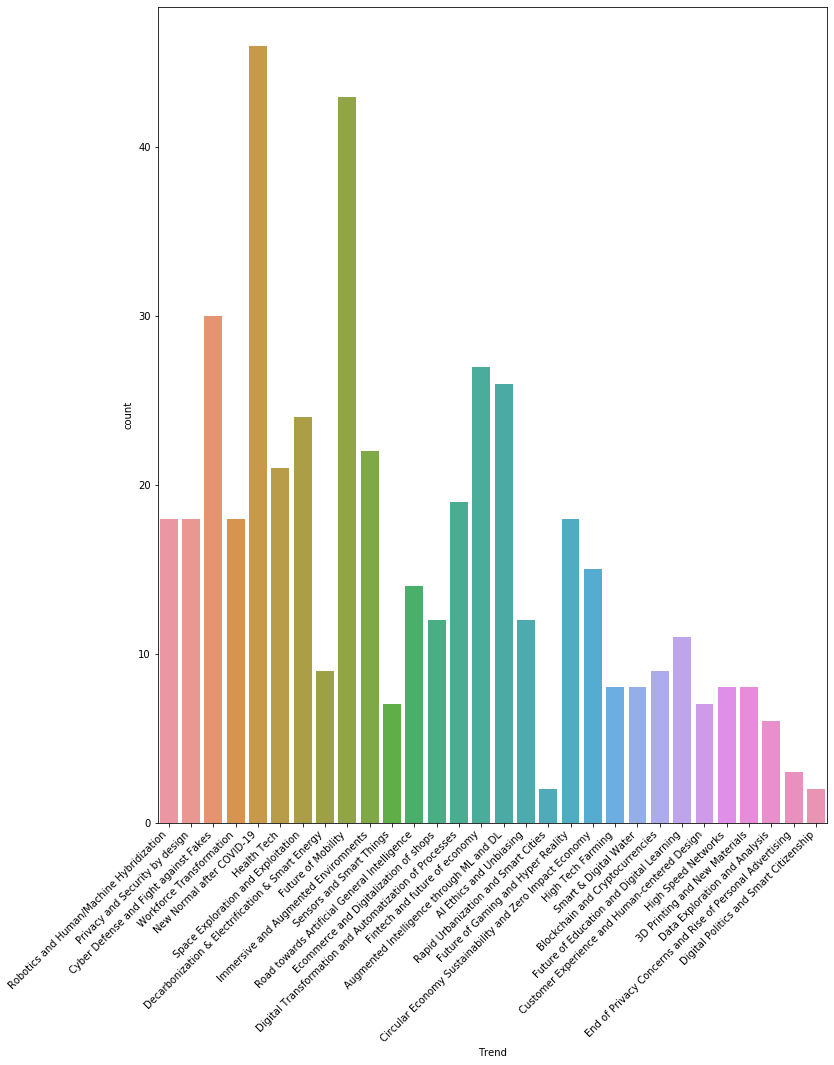

In [20]:
print ("Numero totale di trend: %d" % len(articoli['Trend'].unique()))

plt.figure(figsize=(12,15))
ax=sns.countplot(articoli["Trend"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

<Figure size 432x288 with 0 Axes>

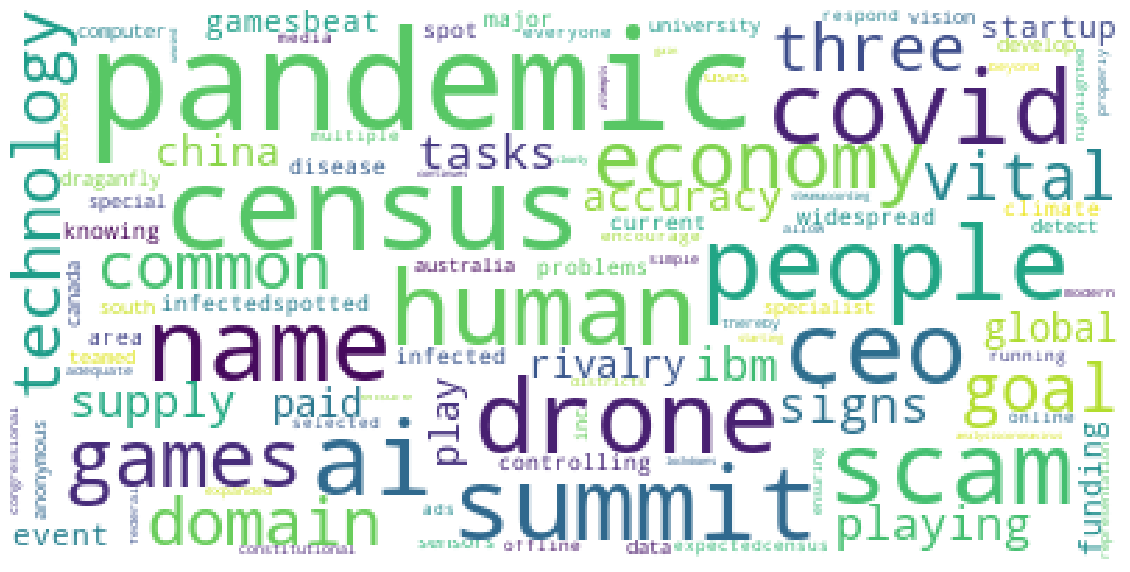

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(articoli['Txt']))

fig = plt.figure(1)
plt.figure(figsize=(20,20)) 
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
import re

corpus = articoli['Txt']
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

In [23]:
# TODO - List all and remove stopwords
list(cv.vocabulary_.keys())[:5]

['pandemic', 'drone', 'spot', 'current', 'climate']

In [24]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]

In [25]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

[Text(0, 0, 'data'),
 Text(0, 0, 'people'),
 Text(0, 0, 'covid'),
 Text(0, 0, 'company'),
 Text(0, 0, 'technology'),
 Text(0, 0, 'ai'),
 Text(0, 0, 'work'),
 Text(0, 0, 'digital'),
 Text(0, 0, 'business'),
 Text(0, 0, 'customers'),
 Text(0, 0, 'need'),
 Text(0, 0, 'help'),
 Text(0, 0, 'team'),
 Text(0, 0, 'industry'),
 Text(0, 0, 'pandemic'),
 Text(0, 0, 'services'),
 Text(0, 0, 'working'),
 Text(0, 0, 'percent'),
 Text(0, 0, 'learning'),
 Text(0, 0, 'health')]

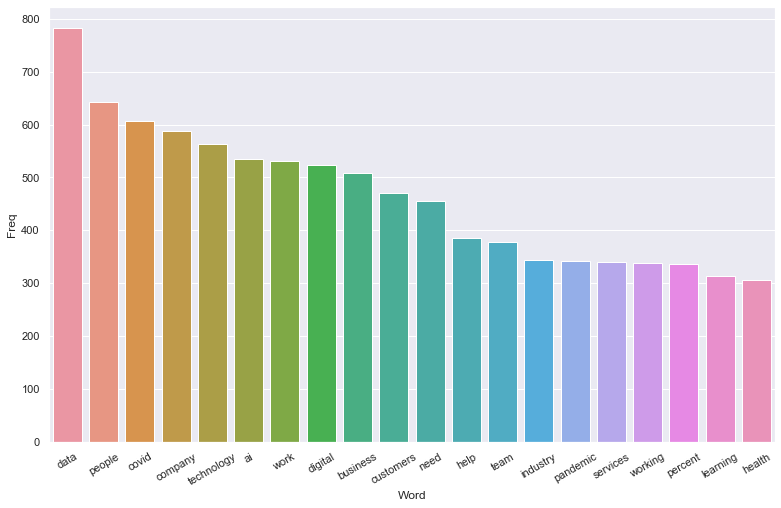

In [26]:
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]

#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

[Text(0, 0, 'machine learning'),
 Text(0, 0, 'artificial intelligence'),
 Text(0, 0, 'covid pandemic'),
 Text(0, 0, 'long term'),
 Text(0, 0, 'decision making'),
 Text(0, 0, 'supply chain'),
 Text(0, 0, 'united states'),
 Text(0, 0, 'supply chains'),
 Text(0, 0, 'climate change'),
 Text(0, 0, 'public health'),
 Text(0, 0, 'vice president'),
 Text(0, 0, 'financial services'),
 Text(0, 0, 'covid crisis'),
 Text(0, 0, 'next normal'),
 Text(0, 0, 'senior partner'),
 Text(0, 0, 'deep learning'),
 Text(0, 0, 'unreal engine'),
 Text(0, 0, 'social distancing'),
 Text(0, 0, 'san francisco'),
 Text(0, 0, 'contact tracing')]

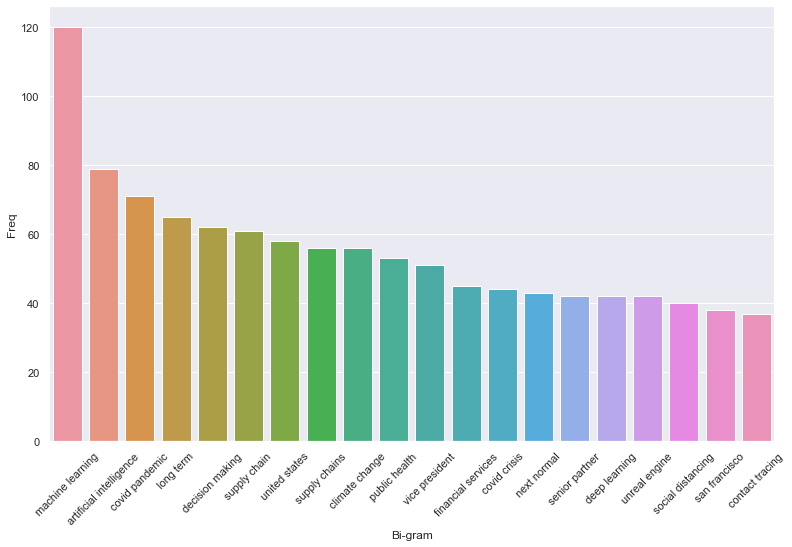

In [27]:
top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
#print(top2_df)

#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h = sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)

## 4. Extract keywords for each row

In [28]:
#https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34
from sklearn.feature_extraction.text import TfidfTransformer
 
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)

# get feature names
feature_names=cv.get_feature_names()

In [29]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [30]:
def extract_keys_for_row(doc, n):  
    #generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())
    
    #extract only the top n
    keywords=extract_topn_from_vector(feature_names,sorted_items, n)
    
    kw = []
    for k in keywords:
        kw.append(k)
        
    return ",".join(kw)
        
extract_keys_for_row(articoli['Txt'][1], 25)

'census,cookies,ad networks,ad,tracking,adobe,party cookies,ads,website,file,party,websites,browser,third,com,third party,page,networks,configuration,net,privacy,representation,anonymous,visitors,performance'

In [31]:
# TODO whitelisting for useful words?
articoli['Keywords'] = articoli['Txt'].apply(lambda x: extract_keys_for_row(x,25))

In [32]:
#articoli.head()
# per Art Tags
#articoli.to_csv('articoli-keyword.csv', sep=";") 

## 5. Train classification model

In [33]:
# convert text to features
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(articoli['Trend'])

MultiLabelBinarizer(classes=None, sparse_output=False)

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
#tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
tfidfconverter = TfidfVectorizer(min_df=5, max_df=0.7, stop_words=stop_words)
X = tfidfconverter.fit_transform(articoli['Txt']).toarray()

In [35]:
# https://stackabuse.com/text-classification-with-python-and-scikit-learn/
# INTERESTING FOR SAVING MODEL
from pandas import Series
y = Series(articoli['Trend']).values

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [37]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train, y_train) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [38]:
y_pred = classifier.predict(X_test)

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
#print(confusion_matrix(y_test,y_pred))

In [40]:
#print(classification_report(y_test,y_pred))

In [41]:
print("Accuracy of model: %f" % accuracy_score(y_test, y_pred))

Accuracy of model: 0.526316


In [42]:
#articoli.to_csv('Articoli Taggati v6.csv', sep=";")

## 6. Test classification model with completely different dataset

In [ ]:
startup = pd.read_csv('startup - startup.csv', sep=",")
del(startup['Unnamed: 0'])
startup.head()

In [ ]:
p_trends = []
for row in startup.itertuples():
    test_data = np.array([row[2]])
    testVectorizerArray = tfidfconverter.transform(test_data).toarray()
    p_trends.append(classifier.predict(testVectorizerArray)[0])

In [ ]:
p_series = pd.Series(p_trends)

startup = pd.concat([startup,p_series], axis=1)
startup.head()

In [43]:
articoli.head()

,ID,Titolo,Data,Trend,Anno,Mese,Txt,Keywords
0,c812e0a3418d624ae60df3ec9e19d184,pandemic drone spot infected,2020-04-03,Robotics and Human/Machine Hybridization,2020.0,4.0,pandemic drone spot infectedspotted current climate major problems controlling pandemic covid knowing infected widespread disease area university south australia canada drone technology specialist draganfly inc teamed develop pandemic drone technology uses special sensors computer vision detect ...,"drone,coughing,detect,respiratory,heart,infected,innovations,pandemic,computer,rate,au,technology,transport innovations,ships,able monitor,teamed,health wellbeing,breathing,airports,wellbeing,detecting,controlling,unveiled,sensing,persons"
1,0e2ef6bd7619374e0531d1551ab2141e,census data anonymous expected,2020-04-07,Privacy and Security by design,2020.0,4.0,census data anonymous expectedcensus multiple ads running online offline media encourage everyone selected census respond constitutional goal census ensure congressional districts properly balanced thereby ensuring adequate representation modern census expanded beyond simple goal allow federal r...,"census,cookies,ad networks,ad,tracking,adobe,party cookies,ads,website,file,party,websites,browser,third,com,third party,page,networks,configuration,net,privacy,representation,anonymous,visitors,performance"
2,8602d8791a1754506303dcfd9a7b79e3,common pandemic scams highlighted domain name analysis,2020-05-11,Cyber Defense and Fight against Fakes,2020.0,5.0,common pandemic scams highlighted domain name analysiscoronavirus lockdowns slowly starting unwind attempts pandemic scam people continues gain steamaccording analysis coronavirusrelated domain names cybersecurity firm cujoai scams fall three general categories fake products financial fraud impe...,"scams,cujo,fake,information,domain names,sites,domain,health,names,attempts,news,scam,people,misleading,charity,legitimate,campaigns,products,malware,claimed,coronavirus,spotted,category,basically,security"
3,2157ac6d12e063b6a38c5c0491e0b322,questions rapidly unfolding future smart fabrics,2020-05-11,Workforce Transformation,2020.0,5.0,questions rapidly unfolding future smart fabricssoon clothes able monitor vital signs analyze results warn,"unfolding,able monitor,analyze,vital,signs,monitor,smart,questions,rapidly,results,able,future"
4,89390733d3f9e1f30bae53de5e2d8a04,types robots playing vital roles covid,2020-05-04,New Normal after COVID-19,2020.0,5.0,types robots playing vital roles covidperfect storm disruptions supply demand workplace practices turned manufacturing supply chains upside social distancing isolation order day manual tasks normally undertaken humans suddenly reach unsafe undertaking tasks without human human contact exactly po...,"playing,roles,vital,tasks,robots,types,supply,undertaken,undertaking,unsafe,without human,upside,supply demand,storm,human,disruptions,appeared robot report,appeared robot,workplace,robot report,suddenly,normally,isolation,supply chains,exactly"


In [50]:
tags = pd.read_csv('art-tags v2.csv', sep=";")
tags = tags.replace(np.nan, '', regex=True)
del (tags["Unnamed: 0"])
del (tags["Titolo"])
del (tags["Trend"])
#del (tags["Tags"])
tags.head()

,ID,Tags,Tag,Tech,Location,Company,People,Application,Vertical
0,c812e0a3418d624ae60df3ec9e19d184,Tech: Drones,,Drones,,,,,
1,0e2ef6bd7619374e0531d1551ab2141e,"Vertical: Advertising, Company: Adobe",,,,Adobe,,,Advertising
2,8602d8791a1754506303dcfd9a7b79e3,,,,,,,,
3,2157ac6d12e063b6a38c5c0491e0b322,Tag: Future,Future,,,,,,
4,89390733d3f9e1f30bae53de5e2d8a04,,,,,,,,


In [51]:
tags = pd.merge(articoli, tags, on = 'ID')

In [52]:
tags.head()

,ID,Titolo,Data,Trend,Anno,Mese,Txt,Keywords,Tags,Tag,Tech,Location,Company,People,Application,Vertical
0,c812e0a3418d624ae60df3ec9e19d184,pandemic drone spot infected,2020-04-03,Robotics and Human/Machine Hybridization,2020.0,4.0,pandemic drone spot infectedspotted current climate major problems controlling pandemic covid knowing infected widespread disease area university south australia canada drone technology specialist draganfly inc teamed develop pandemic drone technology uses special sensors computer vision detect ...,"drone,coughing,detect,respiratory,heart,infected,innovations,pandemic,computer,rate,au,technology,transport innovations,ships,able monitor,teamed,health wellbeing,breathing,airports,wellbeing,detecting,controlling,unveiled,sensing,persons",Tech: Drones,,Drones,,,,,
1,0e2ef6bd7619374e0531d1551ab2141e,census data anonymous expected,2020-04-07,Privacy and Security by design,2020.0,4.0,census data anonymous expectedcensus multiple ads running online offline media encourage everyone selected census respond constitutional goal census ensure congressional districts properly balanced thereby ensuring adequate representation modern census expanded beyond simple goal allow federal r...,"census,cookies,ad networks,ad,tracking,adobe,party cookies,ads,website,file,party,websites,browser,third,com,third party,page,networks,configuration,net,privacy,representation,anonymous,visitors,performance","Vertical: Advertising, Company: Adobe",,,,Adobe,,,Advertising
2,8602d8791a1754506303dcfd9a7b79e3,common pandemic scams highlighted domain name analysis,2020-05-11,Cyber Defense and Fight against Fakes,2020.0,5.0,common pandemic scams highlighted domain name analysiscoronavirus lockdowns slowly starting unwind attempts pandemic scam people continues gain steamaccording analysis coronavirusrelated domain names cybersecurity firm cujoai scams fall three general categories fake products financial fraud impe...,"scams,cujo,fake,information,domain names,sites,domain,health,names,attempts,news,scam,people,misleading,charity,legitimate,campaigns,products,malware,claimed,coronavirus,spotted,category,basically,security",,,,,,,,
3,2157ac6d12e063b6a38c5c0491e0b322,questions rapidly unfolding future smart fabrics,2020-05-11,Workforce Transformation,2020.0,5.0,questions rapidly unfolding future smart fabricssoon clothes able monitor vital signs analyze results warn,"unfolding,able monitor,analyze,vital,signs,monitor,smart,questions,rapidly,results,able,future",Tag: Future,Future,,,,,,
4,89390733d3f9e1f30bae53de5e2d8a04,types robots playing vital roles covid,2020-05-04,New Normal after COVID-19,2020.0,5.0,types robots playing vital roles covidperfect storm disruptions supply demand workplace practices turned manufacturing supply chains upside social distancing isolation order day manual tasks normally undertaken humans suddenly reach unsafe undertaking tasks without human human contact exactly po...,"playing,roles,vital,tasks,robots,types,supply,undertaken,undertaking,unsafe,without human,upside,supply demand,storm,human,disruptions,appeared robot report,appeared robot,workplace,robot report,suddenly,normally,isolation,supply chains,exactly",,,,,,,,


In [53]:
# Per Anomaly Detection
tags.to_csv('Articoli Taggati v7.csv', sep=";")